## Bankruptcy Prediction

**Importing libraries now to be used in later parts of the code**

In [1]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Basic Libraries for Data organization, Statistical operations and Plotting
import numpy as np
import pandas as pd
%matplotlib inline
# For loading .arff files
import seaborn as sns
from scipy.io import arff
# To analyze the type of missing data
import missingno as msno
# Library for performing k-NN and MICE imputations 
import fancyimpute
from sklearn.impute import KNNImputer
# Library to perform Expectation-Maximization (EM) imputation
import impyute as impy
# To perform mean imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#To perform kFold Cross Validation
from sklearn.model_selection import KFold
# Formatted counter of class labels
from collections import Counter
# Ordered Dictionary
from collections import OrderedDict
# Library imbalanced-learn to deal with the data imbalance. To use SMOTE oversampling
from imblearn.over_sampling import SMOTE 



# Impoting classification models
# from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

Our dataset has 5 files for each year. Loading the files and collating in dataframes for later computation

In [2]:
def load_file():
    return [arff.loadarff('data/' + str(i+1) + 'year.arff') for i in range(5)]

def make_dataframes():
    return [pd.DataFrame(data_i_year[0]) for data_i_year in load_file()]

dataframes = make_dataframes()

In [3]:
print(len(dataframes))
dataframes[0].head(5)

5


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


Now we make the attributes with the columnnames in the dataset description

In [4]:
def set_new_headers(dataframes):
    cols = ['X' + str(i+1) for i in range(len(dataframes[0].columns)-1)]
    cols.append('Y')
    for df in dataframes:
        df.columns = cols
set_new_headers(dataframes)


In [5]:
# So now our columns are labelled
dataframes[0].head(5)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [6]:
dataframes[0].dtypes.unique()

array([dtype('float64'), dtype('O')], dtype=object)

In [7]:
# Converting all columns to float now
def convert_columns_type_float(dfs):
    for i in range(5):
        index = 1
        while(index<=63):
            colname = dfs[i].columns[index]
            col = getattr(dfs[i], colname)
            dfs[i][colname] = col.astype(float)
            index+=1
            
convert_columns_type_float(dataframes)

In [8]:
# We now convert our 'Y' Target Variable to either 0 or 1.
# 0-Not Bankrupt (False)
# 1- Bankrupt (True)

dataframes[0]['Y'][0:5]

0    b'0'
1    b'0'
2    b'0'
3    b'0'
4    b'0'
Name: Y, dtype: object

In [9]:
def convert_class_label_type_int(dfs):
    for i in range(len(dfs)):
        col = getattr(dfs[i], 'Y')
        dfs[i]['Y'] = col.astype(int)
        
convert_class_label_type_int(dataframes)

In [10]:
dataframes[0]['Y'][0:5]

0    0
1    0
2    0
3    0
4    0
Name: Y, dtype: int64

### Data Analysis

Checking for missing data.

In [11]:
def drop_nan_rows(dataframes, verbose=False):
    clean_dataframes = [df.dropna(axis=0, how='any') for df in dataframes]
    if verbose:
        for i in range(len(dataframes)):
            print(str(i+1)+'year:','Original Length=', len(dataframes[i]), '\tCleaned Length=', len(clean_dataframes[i]), '\tMissing Data=', len(dataframes[i])-len(clean_dataframes[i]))
    return clean_dataframes
nan_dropped_dataframes = drop_nan_rows(dataframes, verbose=True)

1year: Original Length= 7027 	Cleaned Length= 3194 	Missing Data= 3833
2year: Original Length= 10173 	Cleaned Length= 4088 	Missing Data= 6085
3year: Original Length= 10503 	Cleaned Length= 4885 	Missing Data= 5618
4year: Original Length= 9792 	Cleaned Length= 4769 	Missing Data= 5023
5year: Original Length= 5910 	Cleaned Length= 3031 	Missing Data= 2879


We see that a lot of values are missing from our dataframes. Hence we would have to go for any suitable imputation techniques as we see that it is as high as 50% for some of the dataframes.

**Let's analyse more for our missing data**

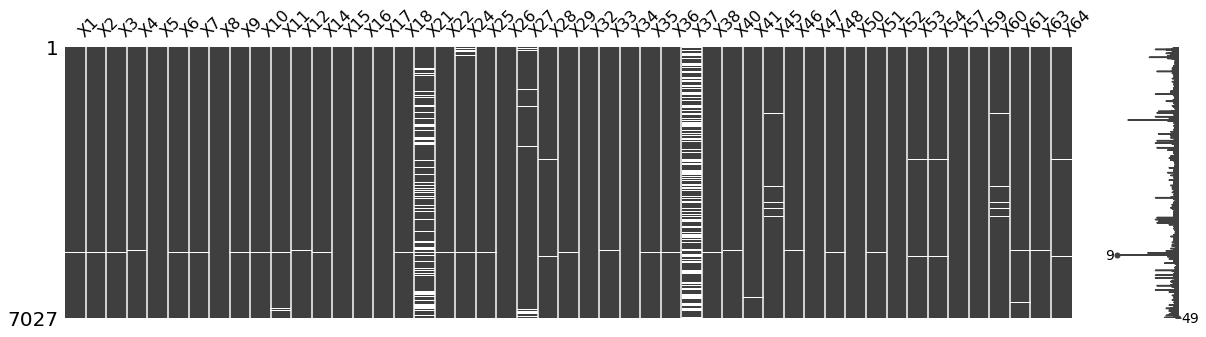

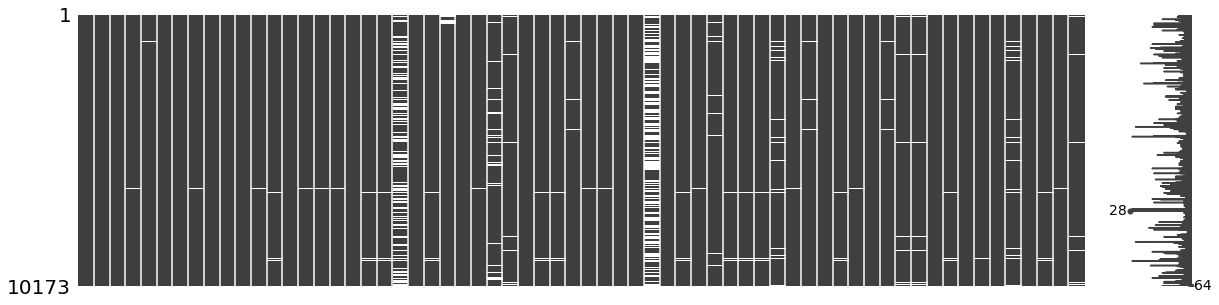

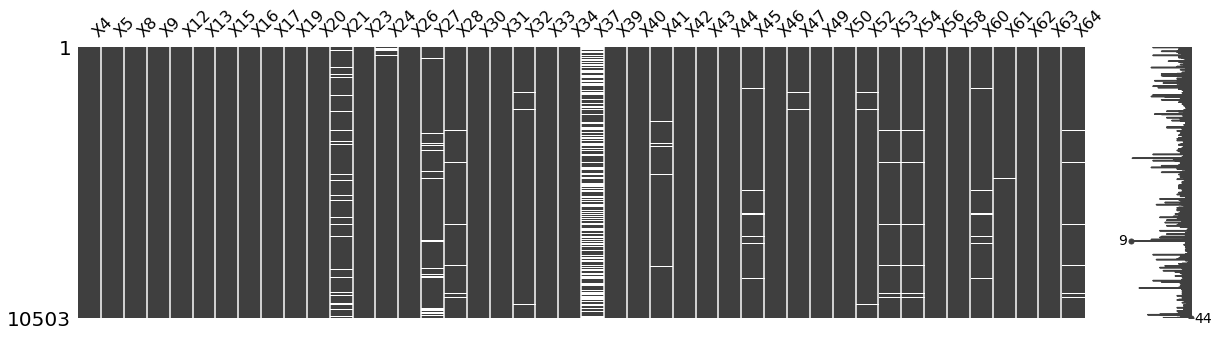

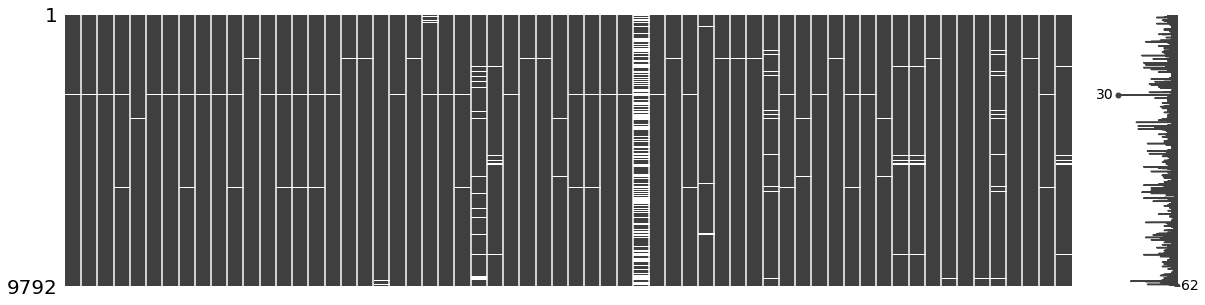

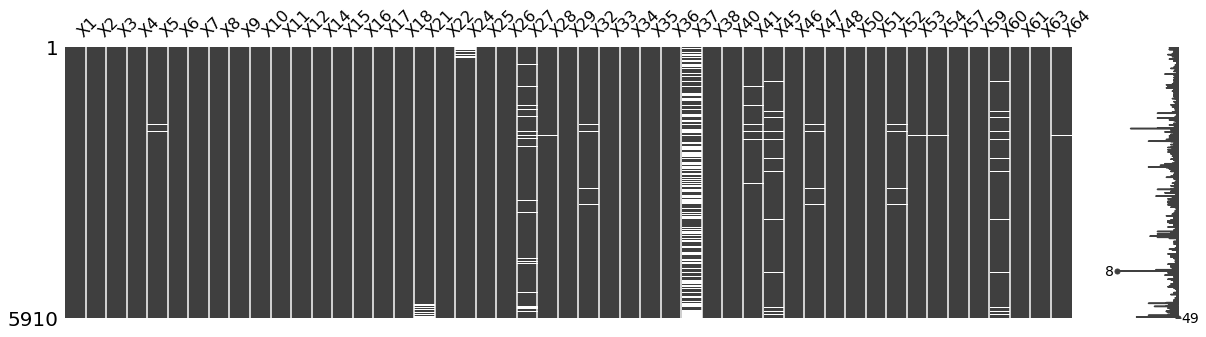

In [12]:
# generate the sparsity matrix (figure) for all the dataframes
def generate_sparsity_matrix(dfs):
    for i in range(5):
        missing_df_i = dfs[i].columns[dfs[i].isnull().any()].tolist()
        msno.matrix(dfs[i][missing_df_i], figsize=(20,5))

generate_sparsity_matrix(dataframes)

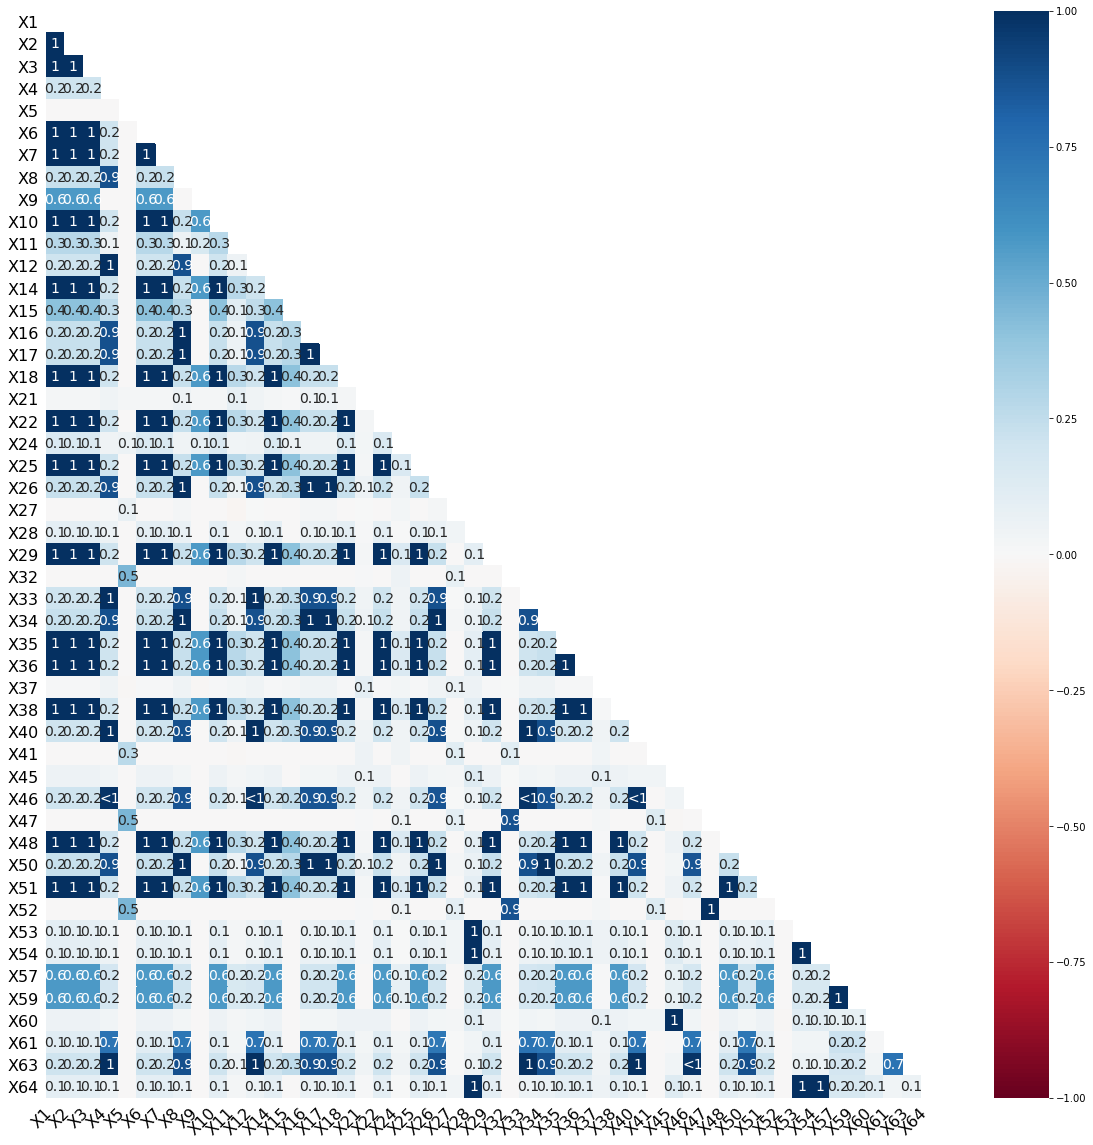

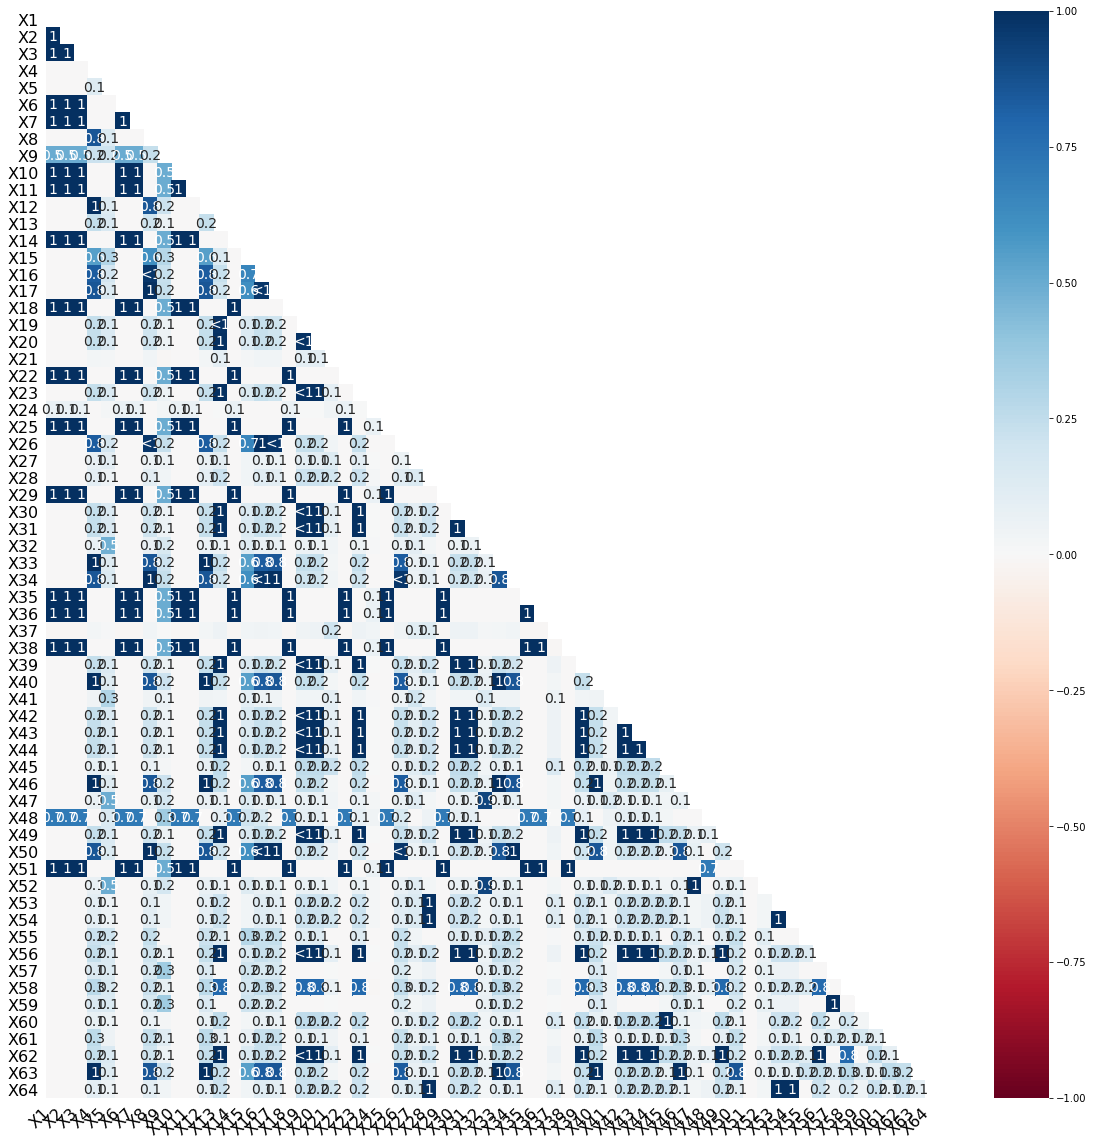

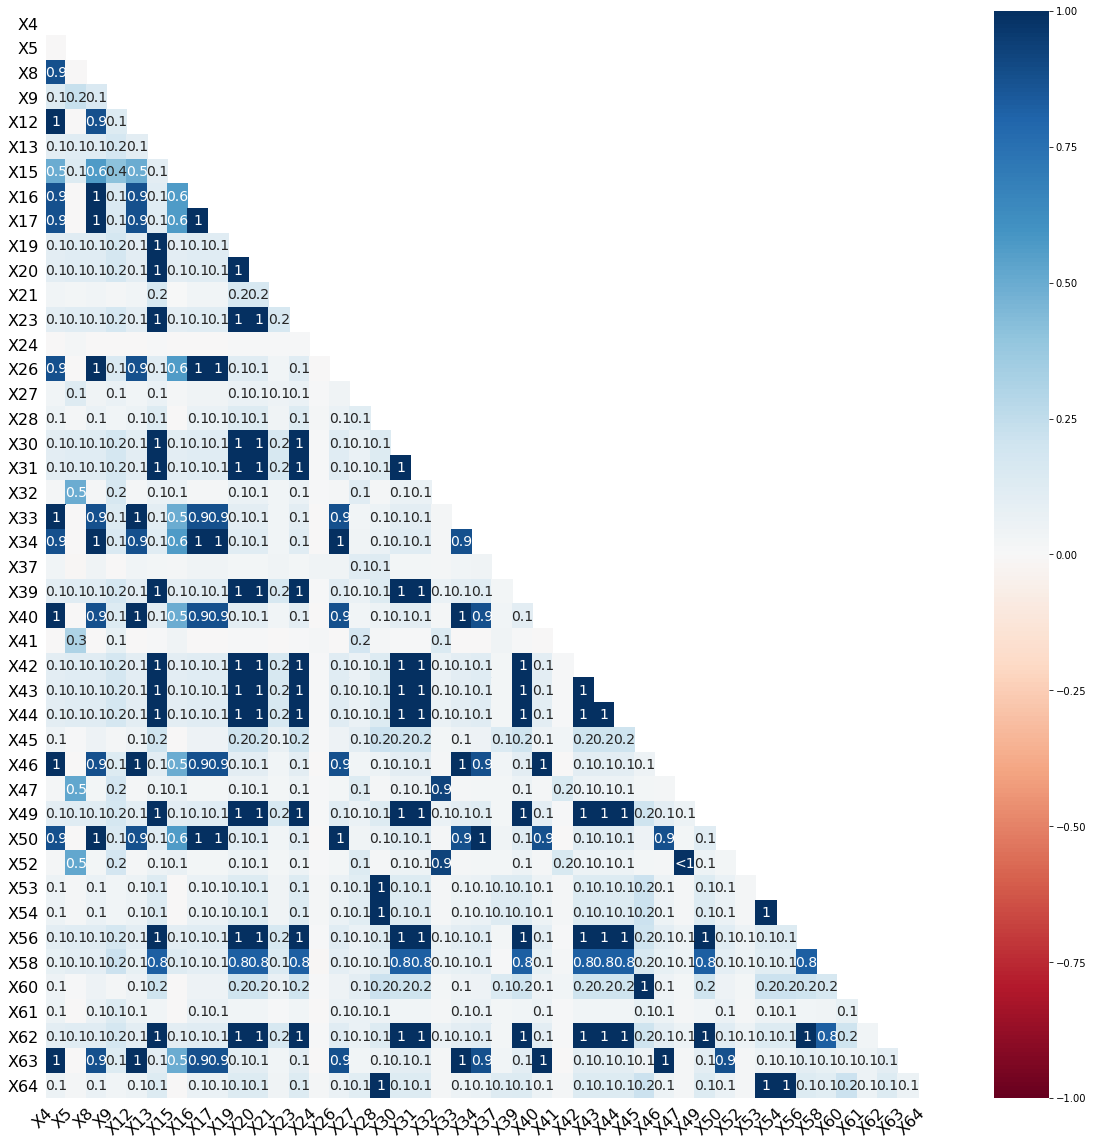

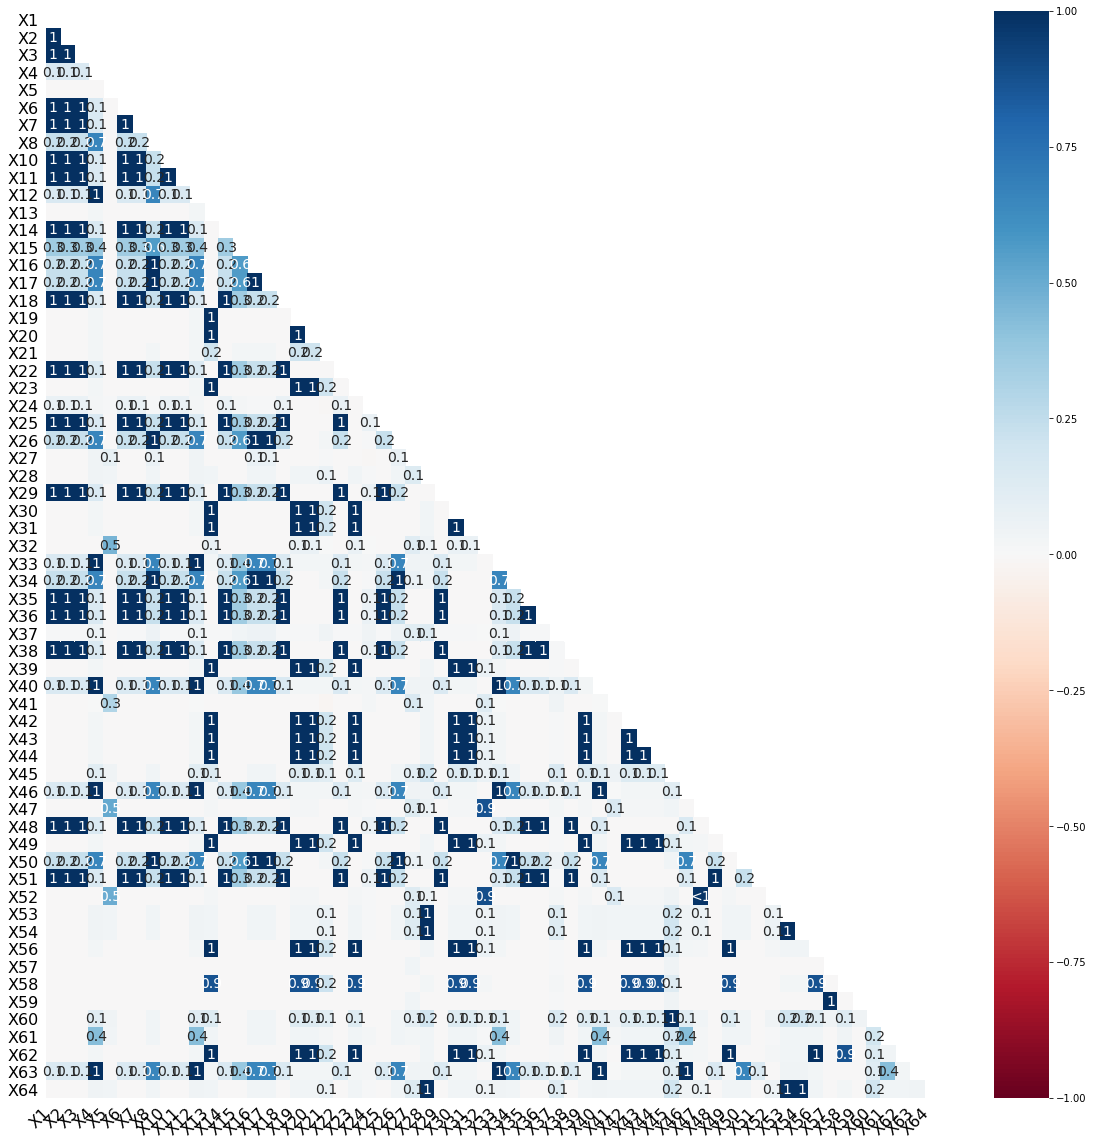

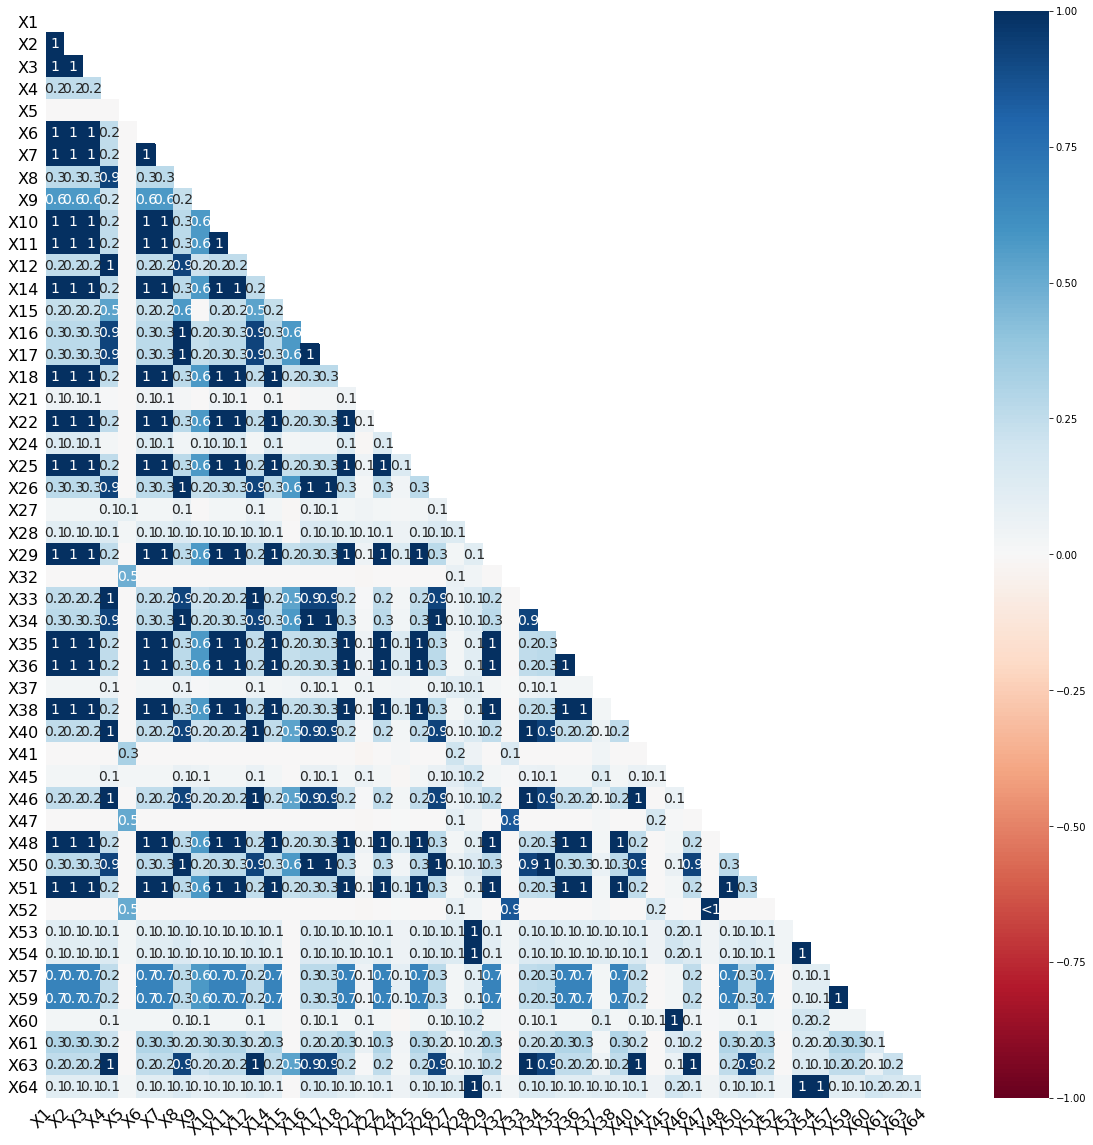

In [13]:
# GETTING CO-RELATION NOW
def generate_heatmap(dfs):
    for i in range(5):
        missing_df_i = dfs[i].columns[dfs[i].isnull().any()].tolist()
        msno.heatmap(dfs[i][missing_df_i], figsize=(20,20))
#         sns.heatmap(dfs[i][missing_df_i], annot=True)
generate_heatmap(dataframes)

The heat maps above, for all the 5 dataframes, describe the degree of nullity relationship between different features. The range of this nullity correlation is from -1 to 1 (-1 ≤ R ≤ 1).
Features with no missing value are excluded in the heatmap. If the nullity correlation is very close to zero (-0.05 < R < 0.05), no value will be displayed.

A perfect positive nullity correlation (R=1) indicates when the first feature and the second feature both have corresponding missing values.

A perfect negative nullity correlation (R=-1) means that one of the features is missing and the second is not missing.

The takeaway is that, in each dataframe, there are some features that are heavily correlated (R = 1 or -1) and also there are features that are not essentially correlated (R values close to 0)

### Imputation 
- Mean Imputation
- k-NN Imputation
- EM imputation


**MEAN IMPUTATION**

In [17]:
def perform_mean_imputation(dfs):
    # Construct an imputer with strategy as 'mean', to mean-impute along the columns
#     imputer = imputer(missing_values=np.nan, strategy='mean', axis=0)
    mean_imputed_dfs = [pd.DataFrame(imputer.fit_transform(df)) for df in dfs]
    for i in range(len(dfs)):
        mean_imputed_dfs[i].columns = dfs[i].columns   
    return mean_imputed_dfs

mean_imputed_dataframes = perform_mean_imputation(dataframes)

In [18]:
mean_imputed_dataframes[0].head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0.0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0.0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0.0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0.0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0.0


**KNN IMPUTATION**

In [19]:
knn_imputer = KNNImputer(n_neighbors=100)
def perform_knn_imputation(dfs):
    knn_imputed_datasets = [knn_imputer.fit_transform(dfs[i]) for i in range(len(dfs))]
    return [pd.DataFrame(data=knn_imputed_datasets[i]) for i in range(len(dfs))]
    
knn_imputed_dataframes = perform_knn_imputation(dataframes)
set_new_headers(knn_imputed_dataframes)

In [20]:
knn_imputed_dataframes[0].head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0.0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0.0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0.0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0.0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0.0


**EM-Imputation**

In [27]:
def perform_EM_imputation(dfs):
    em_imputed_datasets = [impy.imputation.cs.em(dfs[i].values, loops=50, dtype='cont') for i in range(len(dfs))]
    return [pd.DataFrame(data=em_imputed_datasets[i]) for i in range(len(dfs))]

em_imputed_dataframes = perform_EM_imputation(dataframes)
set_new_headers(em_imputed_dataframes)

In [28]:
em_imputed_dataframes[0].head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0.0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0.0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0.0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0.0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0.0


In [29]:
imputed_dataframes_dictionary = OrderedDict()
imputed_dataframes_dictionary['Mean'] = mean_imputed_dataframes
imputed_dataframes_dictionary['k-NN'] = knn_imputed_dataframes
imputed_dataframes_dictionary['EM'] = em_imputed_dataframes

## Dealing with data imbalance
- Data imbalance critically affects the modeling as the models won't have sufficient data belonging to minority classes to train on and this leads to biased models, ultimately leading to poor performance on test data.

In [30]:
def check_data_imbalance(dfs):
    for i in range(len(dfs)):
        print('Dataset: '+str(i+1)+'year')
        print(dfs[i].groupby('Y').size())
        minority_percent = (dfs[i]['Y'].tolist().count(1) / len(dfs[i]['Y'].tolist()))*100
        print('Minority (label 1) percentage: '+  str(minority_percent) + '%')
        print('-'*64)
        
check_data_imbalance(dataframes)

Dataset: 1year
Y
0    6756
1     271
dtype: int64
Minority (label 1) percentage: 3.856553294435748%
----------------------------------------------------------------
Dataset: 2year
Y
0    9773
1     400
dtype: int64
Minority (label 1) percentage: 3.931976801336872%
----------------------------------------------------------------
Dataset: 3year
Y
0    10008
1      495
dtype: int64
Minority (label 1) percentage: 4.712939160239932%
----------------------------------------------------------------
Dataset: 4year
Y
0    9277
1     515
dtype: int64
Minority (label 1) percentage: 5.259395424836601%
----------------------------------------------------------------
Dataset: 5year
Y
0    5500
1     410
dtype: int64
Minority (label 1) percentage: 6.937394247038917%
----------------------------------------------------------------


We have seen in the step above that there is a lot of data imbalance for our datasets, as indicated by the percentage of minority class (label 1) samples among their datasets. With this huge magnitude of data imbalance, the models will not train wel if we leave them as is.

### Oversampling using SMOTE
- SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem.
- It aims to balance class distribution by randomly increasing minority class examples by replicating them.SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [31]:
# Split the features and labels into separate dataframes for all the original dataframes
def split_dataframes_features_labels(dfs):
#     getting features
    feature_dfs = [dfs[i].iloc[:,0:64] for i in range(len(dfs))]
#     getting labels
    label_dfs = [dfs[i].iloc[:,64] for i in range(len(dfs))]
    return feature_dfs, label_dfs

# Performs the SMOTE oversampling fro given dataframes.
def oversample_data_SMOTE(dfs, verbose=False):
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
    #Split the features and labels for each dataframe
    feature_dfs, label_dfs = split_dataframes_features_labels(dfs)
    resampled_feature_arrays = []
    resampled_label_arrays = []
    for i in range(len(dfs)):
        if verbose: print('Dataset: ' + str(i+1) + 'year:')
        if verbose: print('Original dataset shape {}'.format(Counter(label_dfs[i])))
        dfi_features_res, dfi_label_res = smote.fit_sample(feature_dfs[i], label_dfs[i])
        if verbose: print('Resampled dataset shape {}\n'.format(Counter(dfi_label_res)))
        # Append the resampled feature and label arrays of ith dataframe to their respective list of arrays    
        resampled_feature_arrays.append(dfi_features_res)
        resampled_label_arrays.append(dfi_label_res)        
    return resampled_feature_arrays, resampled_label_arrays

# Utility Function to convert the arrays of features and labels to pandas dataframes, and then join them.
# Also re-assign the columns headers.
def restructure_arrays_to_dataframes(feature_arrays, label_arrays):
    resampled_dfs = []
    for i in range(len(feature_arrays)):
        feature_df = pd.DataFrame(data=feature_arrays[i])
        label_df = pd.DataFrame(data=label_arrays[i])
        # Must set the column header for label_df, otherwise it wont join with feature_df, as columns overlap (with col names '0')
        label_df.columns=['Y'] 
        resampled_dfs.append(feature_df.join(label_df))
    # re-assign the column headers for features and labels    
    set_new_headers(resampled_dfs)    
    return resampled_dfs

# Perform SMOTE oversampling on all the imputed dataframes, and return them in a dictionary.
def perform_oversampling_on_imputed_dataframes(df_dict):
    imputed_oversampled_dataframes_dictionary = OrderedDict()
    for key,dfs in df_dict.items():
        print('SMOTE Oversampling for ' + key + ' imputed dataframes\n')
        smote_feature_arrays, smote_label_arrays = oversample_data_SMOTE(dfs, verbose=True)
        oversampled_dataframes = restructure_arrays_to_dataframes(smote_feature_arrays, smote_label_arrays)
        imputed_oversampled_dataframes_dictionary[key] = oversampled_dataframes
        print('-'*100)
    return imputed_oversampled_dataframes_dictionary

imputed_oversampled_dataframes_dictionary = perform_oversampling_on_imputed_dataframes(imputed_dataframes_dictionary)

SMOTE Oversampling for Mean imputed dataframes

Dataset: 1year:
Original dataset shape Counter({0.0: 6756, 1.0: 271})
Resampled dataset shape Counter({0.0: 6756, 1.0: 6756})

Dataset: 2year:
Original dataset shape Counter({0.0: 9773, 1.0: 400})
Resampled dataset shape Counter({0.0: 9773, 1.0: 9773})

Dataset: 3year:
Original dataset shape Counter({0.0: 10008, 1.0: 495})
Resampled dataset shape Counter({0.0: 10008, 1.0: 10008})

Dataset: 4year:
Original dataset shape Counter({0.0: 9277, 1.0: 515})
Resampled dataset shape Counter({0.0: 9277, 1.0: 9277})

Dataset: 5year:
Original dataset shape Counter({0.0: 5500, 1.0: 410})
Resampled dataset shape Counter({0.0: 5500, 1.0: 5500})

----------------------------------------------------------------------------------------------------
SMOTE Oversampling for k-NN imputed dataframes

Dataset: 1year:
Original dataset shape Counter({0.0: 6756, 1.0: 271})
Resampled dataset shape Counter({0.0: 6756, 1.0: 6756})

Dataset: 2year:
Original dataset shape

## ML-Classification Models

In [22]:
def prepare_kfold_cv_data(k, X, y, verbose=False):
    X = X.values
    y = y.values
    kf = KFold(n_splits=k, shuffle=False, random_state=42)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test

In [35]:
# Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()
# Logistic Regression classifier
lr_classifier = LogisticRegression(penalty = 'l2', random_state = 0)
# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')
# eXtreme Gradient Boosting Classifier (XGBClassifier)
xgb_classifier = GradientBoostingClassifier(random_state=0)
# Balanced Bagging Classifier
bb_classifier = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='entropy'), n_estimators = 5, bootstrap = True)

In [36]:
# creating a dictionary of models
models_dictionary = OrderedDict()

models_dictionary['Gaussian Naive Bayes'] = gnb_classifier
models_dictionary['Logistic Regression'] = lr_classifier
models_dictionary['Decision Tree'] = dt_classifier
models_dictionary['Extreme Gradient Boosting'] = xgb_classifier
models_dictionary['Random Forest'] = rf_classifier
models_dictionary['Balanced Bagging'] = bb_classifier

In [37]:
# perform data modeling
def perform_data_modeling(_models_, _imputers_, verbose=False, k_folds=5):
    
    # 7 Models
    # 4 Imputers
    # 5 datasets (for 5 years)
    # 7 metrics, averaged over all the K-Folds
    model_results = OrderedDict()
    
    # Iterate over the models
    for model_name, clf in _models_.items():
        if verbose: print("-"*120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()
        
        # Iterate over the different imputed_data mechanisms (Mean, k-NN, EM, MICE)
        for imputer_name, dataframes_list in _imputers_.items():
            if verbose: print('\tImputer Technique: ' + '\033[1m' + imputer_name + '\033[0m')
            
            # call the split_dataframes_features_labels function to get a list of features and labels for all the dataframes
            feature_dfs, label_dfs = split_dataframes_features_labels(dataframes_list)            
            
            year_results = OrderedDict()
            
            # Iterate over dataframe_list individually
            for df_index in range(len(dataframes_list)):
                if verbose: print('\t\tDataset: ' + '\033[1m' + str(df_index+1) + 'year' + '\033[0m')
                
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
                X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, feature_dfs[df_index], label_dfs[df_index], verbose)
                
                metrics_results = OrderedDict()
                accuracy_list = np.zeros([k_folds])
                precision_list = np.zeros([k_folds,2])
                recall_list = np.zeros([k_folds,2])
                TN_list = np.zeros([k_folds])
                FP_list = np.zeros([k_folds])
                FN_list = np.zeros([k_folds])
                TP_list = np.zeros([k_folds])                
                
                # Iterate over all the k-folds
                for k_index in range(k_folds):
                    X_train = X_train_list[k_index]
                    y_train = y_train_list[k_index]
                    X_test = X_test_list[k_index]
                    y_test = y_test_list[k_index]
                    
                    # Fit the model and 
                    clf = clf.fit(X_train, y_train)
                    y_test_predicted = clf.predict(X_test)
                    
                    #code for calculating accuracy 
                    _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
                    accuracy_list[k_index] = _accuracy_
                    
                    #code for calculating recall 
                    _recalls_ = recall_score(y_test, y_test_predicted, average=None)
                    recall_list[k_index] = _recalls_
                    
                    #code for calculating precision 
                    _precisions_ = precision_score(y_test, y_test_predicted, average=None)
                    precision_list[k_index] = _precisions_
                    
                    #code for calculating confusion matrix 
                    _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
                    TN_list[k_index] = _confusion_matrix_[0][0]
                    FP_list[k_index] = _confusion_matrix_[0][1]
                    FN_list[k_index] = _confusion_matrix_[1][0]
                    TP_list[k_index] = _confusion_matrix_[1][1]
                
                # creating a metrics dictionary
                metrics_results['Accuracy'] = np.mean(accuracy_list)
                metrics_results['Precisions'] = np.mean(precision_list, axis=0)
                metrics_results['Recalls'] = np.mean(recall_list, axis=0)
                metrics_results['TN'] = np.mean(TN_list)
                metrics_results['FP'] = np.mean(FP_list)
                metrics_results['FN'] = np.mean(FN_list)
                metrics_results['TP'] = np.mean(TP_list)
                
                if verbose:
                    print('\t\t\tAccuracy:', metrics_results['Accuracy'])
                    print('\t\t\tPrecision:', metrics_results['Precisions'])
                    print('\t\t\tRecall:', metrics_results['Recalls'])
                
                year_results[str(df_index+1)+'year'] = metrics_results   
                
            imputer_results[imputer_name] = year_results
            
        model_results[model_name] = imputer_results  
        
    return model_results

L2 - penalty in logistic regression

In [38]:
results = perform_data_modeling(models_dictionary, imputed_oversampled_dataframes_dictionary, verbose=True, k_folds=5)

------------------------------------------------------------------------------------------------------------------------ 
 Model: Gaussian Naive Bayes Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.5156118171190658
			Precision: [0.55384615 0.50140311]
			Recall: [0.02427755 0.59385805]
		Dataset: 2year
			Accuracy: 0.512558257912261
			Precision: [0.50166667 0.50007918]
			Recall: [0.02522294 0.5874152 ]
		Dataset: 3year
			Accuracy: 0.5196079463878615
			Precision: [0.53333333 0.50124288]
			Recall: [0.03492381 0.58701092]
		Dataset: 4year
			Accuracy: 0.5144681833930015
			Precision: [0.51151515 0.50056402]
			Recall: [0.03805172 0.5774183 ]
		Dataset: 5year
			Accuracy: 0.517090909090909
			Precision: [0.51764706 0.50100913]
			Recall: [0.04245455 0.57654545]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.5142057526891879
			Precision: [0.55172414 0.50121029]
			Recall: [0.02257475 0.59378392]
		Dataset: 2year
			Accuracy: 0.5104095670100934
			Precis

			Accuracy: 0.9611415904199724
			Precision: [0.59570011 0.59156563]
			Recall: [0.56561341 0.58911362]
		Dataset: 5year
			Accuracy: 0.9542727272727273
			Precision: [0.59386617 0.58985765]
			Recall: [0.56209091 0.584     ]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.9719539355482147
			Precision: [0.59833585 0.59434783]
			Recall: [0.57468837 0.59356153]
		Dataset: 2year
			Accuracy: 0.9684340616022178
			Precision: [0.59599384 0.59531091]
			Recall: [0.57472603 0.58935891]
		Dataset: 3year
			Accuracy: 0.9521393545250654
			Precision: [0.59538698 0.59074074]
			Recall: [0.55803256 0.58711079]
		Dataset: 4year
			Accuracy: 0.9529496848082593
			Precision: [0.59584969 0.58869295]
			Recall: [0.55521106 0.58986803]
		Dataset: 5year
			Accuracy: 0.9458181818181819
			Precision: [0.59215686 0.5874225 ]
			Recall: [0.55290909 0.58263636]


## Model Analysis

In [39]:
# model -> imputer -> year
def perform_model_ranking(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_accuracy = 0
            for year, metrics in imputer_details.items():
                mean_accuracy += metrics['Accuracy']
            mean_accuracy = mean_accuracy/len(imputer_details)
            row.append(mean_accuracy)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

In [44]:
perform_model_ranking(models_dictionary, imputed_oversampled_dataframes_dictionary, results)

,-,Mean,k-NN
0,Gaussian Naive Bayes,0.515867,0.516134
1,Logistic Regression,0.251477,0.266712
2,Decision Tree,0.911065,0.882285
3,Extreme Gradient Boosting,0.906654,0.866183
4,Random Forest,0.929587,0.907303
5,Balanced Bagging,0.968510,0.958259


Effect of number of estimators on accuracy of balanced bagging classifier

In [46]:
results_by_estimators = []
for i in range(29):
    
    models_dictionary['Balanced Bagging'] = BalancedBaggingClassifier(
        base_estimator = RandomForestClassifier(criterion='entropy'), 
        n_estimators = i+1, 
        bootstrap = True)
    
    results = perform_data_modeling(models_dictionary,
                                    imputed_oversampled_dataframes_dictionary,
                                    verbose=True, k_folds=5)
    
    results_by_estimators.append(results)

------------------------------------------------------------------------------------------------------------------------ 
 Model: Gaussian Naive Bayes Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.5156118171190658
			Precision: [0.55384615 0.50140311]
			Recall: [0.02427755 0.59385805]
		Dataset: 2year
			Accuracy: 0.512558257912261
			Precision: [0.50166667 0.50007918]
			Recall: [0.02522294 0.5874152 ]
		Dataset: 3year
			Accuracy: 0.5196079463878615
			Precision: [0.53333333 0.50124288]
			Recall: [0.03492381 0.58701092]
		Dataset: 4year
			Accuracy: 0.5144681833930015
			Precision: [0.51151515 0.50056402]
			Recall: [0.03805172 0.5774183 ]
		Dataset: 5year
			Accuracy: 0.517090909090909
			Precision: [0.51764706 0.50100913]
			Recall: [0.04245455 0.57654545]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.5142057526891879
			Precision: [0.55172414 0.50121029]
			Recall: [0.02257475 0.59378392]
		Dataset: 2year
			Accuracy: 0.5104095670100934
			Precis

			Accuracy: 0.9540271110655943
			Precision: [0.59201726 0.59192246]
			Recall: [0.56388896 0.58210794]
		Dataset: 5year
			Accuracy: 0.9496363636363636
			Precision: [0.59352451 0.59034853]
			Recall: [0.56109091 0.58045455]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.9661813107293948
			Precision: [0.59683497 0.5936    ]
			Recall: [0.57157989 0.58978764]
		Dataset: 2year
			Accuracy: 0.9619364323526467
			Precision: [0.5943734  0.59447288]
			Recall: [0.57273062 0.58362897]
		Dataset: 3year
			Accuracy: 0.9449448752596392
			Precision: [0.59307888 0.58979392]
			Recall: [0.55613388 0.58021654]
		Dataset: 4year
			Accuracy: 0.9461586846419292
			Precision: [0.59312639 0.58814893]
			Recall: [0.55380971 0.58291608]
		Dataset: 5year
			Accuracy: 0.9368181818181819
			Precision: [0.59287054 0.58730159]
			Recall: [0.55       0.57681818]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Gaussian

			Accuracy: 0.8933369403516794
			Precision: [0.58648925 0.58252806]
			Recall: [0.52151134 0.55628608]
		Dataset: 4year
			Accuracy: 0.8968426641564635
			Precision: [0.58683628 0.58255386]
			Recall: [0.52513665 0.55634491]
		Dataset: 5year
			Accuracy: 0.901818181818182
			Precision: [0.58690037 0.5844086 ]
			Recall: [0.53190909 0.55554545]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Balanced Bagging Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.9803890350743876
			Precision: [0.59716841 0.59602941]
			Recall: [0.58482723 0.59215604]
		Dataset: 2year
			Accuracy: 0.9769775958032451
			Precision: [0.5950279  0.59669763]
			Recall: [0.58434437 0.58848939]
		Dataset: 3year
			Accuracy: 0.9641790884608771
			Precision: [0.59349024 0.59312064]
			Recall: [0.57242118 0.58506283]
		Dataset: 4year
			Accuracy: 0.9611415904199724
			Precision: [0.59551422 0.59277748]
			Recall: [0.56

			Accuracy: 0.9564114002233997
			Precision: [0.59461481 0.59282051]
			Recall: [0.56913734 0.580981  ]
		Dataset: 2year
			Accuracy: 0.935179816529368
			Precision: [0.59075975 0.59020908]
			Recall: [0.55349401 0.57216915]
		Dataset: 3year
			Accuracy: 0.9268098875893032
			Precision: [0.5886341  0.58908363]
			Recall: [0.54759158 0.56807679]
		Dataset: 4year
			Accuracy: 0.9090237299904633
			Precision: [0.58570661 0.58627027]
			Recall: [0.53580876 0.55920275]
		Dataset: 5year
			Accuracy: 0.919727272727273
			Precision: [0.58939535 0.58542222]
			Recall: [0.542      0.56509091]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.9262178739909299
			Precision: [0.59130435 0.58619698]
			Recall: [0.54508225 0.56980639]
		Dataset: 2year
			Accuracy: 0.9152776561924446
			Precision: [0.58886576 0.58600906]
			Recall: [0.54049786 0.56219262]
		Dataset: 3year
			Accuracy: 0.8982330934117095
			Precision: [0.58975431 0.58220096]
			Recall: [0.52510829 0.55893325]
		Dataset: 4year
	

			Accuracy: 0.8881051922186414
			Precision: [0.58137184 0.58572513]
			Recall: [0.5258447  0.54575802]
		Dataset: 2year
			Accuracy: 0.8591033348839552
			Precision: [0.57863205 0.58268625]
			Recall: [0.51302585 0.52668762]
		Dataset: 3year
			Accuracy: 0.8448766447142665
			Precision: [0.57371429 0.58139779]
			Recall: [0.50197939 0.52026669]
		Dataset: 4year
			Accuracy: 0.8509227248197064
			Precision: [0.57392654 0.58042745]
			Recall: [0.50422561 0.52374061]
		Dataset: 5year
			Accuracy: 0.8879090909090909
			Precision: [0.5752381  0.58315789]
			Recall: [0.53263636 0.53427273]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Random Forest Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.9554494786476523
			Precision: [0.59310345 0.59093567]
			Recall: [0.56632351 0.58113013]
		Dataset: 2year
			Accuracy: 0.935794281541907
			Precision: [0.59170082 0.59151763]
			Recall: [0.55554

			Accuracy: 0.9383526213300846
			Precision: [0.58610914 0.59426801]
			Recall: [0.56573568 0.56263101]
		Dataset: 2year
			Accuracy: 0.9071941529122578
			Precision: [0.57852349 0.58990675]
			Recall: [0.55006716 0.54096263]
		Dataset: 3year
			Accuracy: 0.8929371153453094
			Precision: [0.5758252  0.58812095]
			Recall: [0.53979922 0.5346555 ]
		Dataset: 4year
			Accuracy: 0.8741514155119805
			Precision: [0.57540323 0.58668211]
			Recall: [0.52697052 0.52783675]
		Dataset: 5year
			Accuracy: 0.9206363636363637
			Precision: [0.58105995 0.58894185]
			Recall: [0.554      0.55145455]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.8881051922186414
			Precision: [0.58137184 0.58572513]
			Recall: [0.5258447  0.54575802]
		Dataset: 2year
			Accuracy: 0.8591033348839552
			Precision: [0.57863205 0.58268625]
			Recall: [0.51302585 0.52668762]
		Dataset: 3year
			Accuracy: 0.8448766447142665
			Precision: [0.57371429 0.58139779]
			Recall: [0.50197939 0.52026669]
		Dataset: 4year

			Accuracy: 0.903497142331368
			Precision: [0.58717949 0.58415698]
			Recall: [0.53457327 0.55456149]
		Dataset: 2year
			Accuracy: 0.8834042497508865
			Precision: [0.58068182 0.57921946]
			Recall: [0.52407425 0.53927325]
		Dataset: 3year
			Accuracy: 0.8732022411762607
			Precision: [0.57687688 0.57665835]
			Recall: [0.5174632  0.53250639]
		Dataset: 4year
			Accuracy: 0.867684475599242
			Precision: [0.57946726 0.57506548]
			Recall: [0.50864304 0.5362428 ]
		Dataset: 5year
			Accuracy: 0.8836363636363636
			Precision: [0.57902484 0.5771788 ]
			Recall: [0.52363636 0.53809091]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Extreme Gradient Boosting Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.9383526213300846
			Precision: [0.58610914 0.59426801]
			Recall: [0.56573568 0.56263101]
		Dataset: 2year
			Accuracy: 0.9071941529122578
			Precision: [0.57852349 0.58990675]
			Recal

			Accuracy: 0.9358373362053787
			Precision: [0.5892911  0.58619186]
			Recall: [0.5534435 0.570104 ]
		Dataset: 2year
			Accuracy: 0.9064273867309947
			Precision: [0.58418605 0.58257345]
			Recall: [0.53476773 0.55503087]
		Dataset: 3year
			Accuracy: 0.9112218533402645
			Precision: [0.57960591 0.58195641]
			Recall: [0.53899657 0.55299043]
		Dataset: 4year
			Accuracy: 0.8942016776814903
			Precision: [0.58274002 0.5826602 ]
			Recall: [0.52998724 0.54691449]
		Dataset: 5year
			Accuracy: 0.9076363636363636
			Precision: [0.58348794 0.5802139 ]
			Recall: [0.53654545 0.55290909]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.903497142331368
			Precision: [0.58717949 0.58415698]
			Recall: [0.53457327 0.55456149]
		Dataset: 2year
			Accuracy: 0.8834042497508865
			Precision: [0.58068182 0.57921946]
			Recall: [0.52407425 0.53927325]
		Dataset: 3year
			Accuracy: 0.8732022411762607
			Precision: [0.57687688 0.57665835]
			Recall: [0.5174632  0.53250639]
		Dataset: 4year
		

			Accuracy: 0.2707923016699103
			Precision: [0.51645044 0.54116129]
			Recall: [0.28542311 0.10897045]
		Dataset: 2year
			Accuracy: 0.2245444868193866
			Precision: [0.508677   0.53006834]
			Recall: [0.26971424 0.06834013]
		Dataset: 3year
			Accuracy: 0.23920924191970902
			Precision: [0.50613849 0.52931034]
			Recall: [0.28751686 0.06189234]
		Dataset: 4year
			Accuracy: 0.23665152264594008
			Precision: [0.51550308 0.51718661]
			Recall: [0.21113481 0.14182228]
		Dataset: 5year
			Accuracy: 0.36236363636363633
			Precision: [0.53558179 0.54161736]
			Recall: [0.26327273 0.23745455]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Decision Tree Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.9358373362053787
			Precision: [0.5892911  0.58619186]
			Recall: [0.5534435 0.570104 ]
		Dataset: 2year
			Accuracy: 0.9064273867309947
			Precision: [0.58418605 0.58257345]
			Recall: [0.534

			Accuracy: 0.2784890160972005
			Precision: [0.52311465 0.53538749]
			Recall: [0.27141925 0.13507976]
		Dataset: 2year
			Accuracy: 0.195383477959905
			Precision: [0.50821321 0.52656587]
			Recall: [0.24004073 0.06793043]
		Dataset: 3year
			Accuracy: 0.21767852432354054
			Precision: [0.504209   0.52616487]
			Recall: [0.27982677 0.04515734]
		Dataset: 4year
			Accuracy: 0.22156126500874143
			Precision: [0.51321093 0.52002706]
			Recall: [0.21361797 0.12387989]
		Dataset: 5year
			Accuracy: 0.34427272727272723
			Precision: [0.52667683 0.53941441]
			Recall: [0.27563636 0.20045455]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.2707923016699103
			Precision: [0.51645044 0.54116129]
			Recall: [0.28542311 0.10897045]
		Dataset: 2year
			Accuracy: 0.2245444868193866
			Precision: [0.508677   0.53006834]
			Recall: [0.26971424 0.06834013]
		Dataset: 3year
			Accuracy: 0.23920924191970902
			Precision: [0.50613849 0.52931034]
			Recall: [0.28751686 0.06189234]
		Dataset: 4y

			Accuracy: 0.5104095670100934
			Precision: [0.50413223 0.50015839]
			Recall: [0.02389293 0.58675005]
		Dataset: 3year
			Accuracy: 0.519757659278019
			Precision: [0.53333333 0.50132364]
			Recall: [0.03697225 0.5852623 ]
		Dataset: 4year
			Accuracy: 0.5136596306892672
			Precision: [0.50941176 0.50048009]
			Recall: [0.0384829  0.57601703]
		Dataset: 5year
			Accuracy: 0.5226363636363637
			Precision: [0.52297297 0.50165692]
			Recall: [0.05054545 0.57518182]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Logistic Regression Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.2784890160972005
			Precision: [0.52311465 0.53538749]
			Recall: [0.27141925 0.13507976]
		Dataset: 2year
			Accuracy: 0.195383477959905
			Precision: [0.50821321 0.52656587]
			Recall: [0.24004073 0.06793043]
		Dataset: 3year
			Accuracy: 0.21767852432354054
			Precision: [0.504209   0.52616487]
			Recall: [0

			Accuracy: 0.512558257912261
			Precision: [0.50166667 0.50007918]
			Recall: [0.02522294 0.5874152 ]
		Dataset: 3year
			Accuracy: 0.5196079463878615
			Precision: [0.53333333 0.50124288]
			Recall: [0.03492381 0.58701092]
		Dataset: 4year
			Accuracy: 0.5144681833930015
			Precision: [0.51151515 0.50056402]
			Recall: [0.03805172 0.5774183 ]
		Dataset: 5year
			Accuracy: 0.517090909090909
			Precision: [0.51764706 0.50100913]
			Recall: [0.04245455 0.57654545]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.5142057526891879
			Precision: [0.55172414 0.50121029]
			Recall: [0.02257475 0.59378392]
		Dataset: 2year
			Accuracy: 0.5104095670100934
			Precision: [0.50413223 0.50015839]
			Recall: [0.02389293 0.58675005]
		Dataset: 3year
			Accuracy: 0.519757659278019
			Precision: [0.53333333 0.50132364]
			Recall: [0.03697225 0.5852623 ]
		Dataset: 4year
			Accuracy: 0.5136596306892672
			Precision: [0.50941176 0.50048009]
			Recall: [0.0384829  0.57601703]
		Dataset: 5year
		

			Accuracy: 0.9714359925219476
			Precision: [0.59847677 0.59323254]
			Recall: [0.57298524 0.59422759]
		Dataset: 2year
			Accuracy: 0.9694573935550395
			Precision: [0.59730849 0.59514416]
			Recall: [0.57431671 0.59135397]
		Dataset: 3year
			Accuracy: 0.9535882179274635
			Precision: [0.59528447 0.59064327]
			Recall: [0.55903174 0.58746055]
		Dataset: 4year
			Accuracy: 0.9530037239038016
			Precision: [0.59606521 0.58850932]
			Recall: [0.55467206 0.59046095]
		Dataset: 5year
			Accuracy: 0.9465454545454545
			Precision: [0.59251637 0.58744474]
			Recall: [0.55327273 0.58318182]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Gaussian Naive Bayes Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.5156118171190658
			Precision: [0.55384615 0.50140311]
			Recall: [0.02427755 0.59385805]
		Dataset: 2year
			Accuracy: 0.512558257912261
			Precision: [0.50166667 0.50007918]
			Recall: [

			Accuracy: 0.9832013282387937
			Precision: [0.5977662  0.59676233]
			Recall: [0.58675184 0.59371001]
		Dataset: 2year
			Accuracy: 0.9785637053713675
			Precision: [0.59551935 0.59650386]
			Recall: [0.58439551 0.59017767]
		Dataset: 3year
			Accuracy: 0.9655782139419411
			Precision: [0.59447236 0.59344262]
			Recall: [0.57227154 0.58726093]
		Dataset: 4year
			Accuracy: 0.961465084134659
			Precision: [0.59624724 0.59189047]
			Recall: [0.5647512  0.59073042]
		Dataset: 5year
			Accuracy: 0.9554545454545454
			Precision: [0.59404651 0.58986667]
			Recall: [0.56272727 0.58463636]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.9723239496209081
			Precision: [0.59848024 0.59365079]
			Recall: [0.57416961 0.59415357]
		Dataset: 2year
			Accuracy: 0.9675132800626006
			Precision: [0.59628866 0.59492128]
			Recall: [0.57288419 0.59022862]
		Dataset: 3year
			Accuracy: 0.9536382553244908
			Precision: [0.59509202 0.59091353]
			Recall: [0.55913181 0.5874606 ]
		Dataset: 4year


			Accuracy: 0.929622266347149
			Precision: [0.59387443 0.58796562]
			Recall: [0.54819189 0.57224716]
		Dataset: 2year
			Accuracy: 0.9168127588050135
			Precision: [0.59073881 0.58782084]
			Recall: [0.54034502 0.56572246]
		Dataset: 3year
			Accuracy: 0.8965342925872528
			Precision: [0.5890625  0.58214114]
			Recall: [0.52520814 0.55678503]
		Dataset: 4year
			Accuracy: 0.8966269871533672
			Precision: [0.58787879 0.58417722]
			Recall: [0.52675393 0.5558595 ]
		Dataset: 5year
			Accuracy: 0.8941818181818183
			Precision: [0.58802619 0.58320071]
			Recall: [0.528      0.55172727]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Balanced Bagging Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.9833495310334517
			Precision: [0.59791356 0.59676471]
			Recall: [0.58630789 0.59437607]
		Dataset: 2year
			Accuracy: 0.9788196168720751
			Precision: [0.59573171 0.59711489]
			Recall: [0.58

			Accuracy: 0.9504911202920899
			Precision: [0.59372197 0.59208211]
			Recall: [0.56499297 0.57839098]
		Dataset: 2year
			Accuracy: 0.9374304690009743
			Precision: [0.59094148 0.59197531]
			Recall: [0.55845682 0.57042955]
		Dataset: 3year
			Accuracy: 0.9229627354908393
			Precision: [0.59055838 0.58780128]
			Recall: [0.54404383 0.56807627]
		Dataset: 4year
			Accuracy: 0.9130655783309038
			Precision: [0.58813747 0.58342947]
			Recall: [0.53677795 0.56200428]
		Dataset: 5year
			Accuracy: 0.9222727272727272
			Precision: [0.59028945 0.58565102]
			Recall: [0.54754545 0.56263636]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.9256264320177185
			Precision: [0.59181198 0.58770788]
			Recall: [0.5447881  0.57054625]
		Dataset: 2year
			Accuracy: 0.9156870858056593
			Precision: [0.59027419 0.58836032]
			Recall: [0.54413125 0.56086201]
		Dataset: 3year
			Accuracy: 0.8918376028168684
			Precision: [0.58573612 0.58254902]
			Recall: [0.52266004 0.55328853]
		Dataset: 4year

			Accuracy: 0.8881051922186414
			Precision: [0.58137184 0.58572513]
			Recall: [0.5258447  0.54575802]
		Dataset: 2year
			Accuracy: 0.8591033348839552
			Precision: [0.57863205 0.58268625]
			Recall: [0.51302585 0.52668762]
		Dataset: 3year
			Accuracy: 0.8448766447142665
			Precision: [0.57371429 0.58139779]
			Recall: [0.50197939 0.52026669]
		Dataset: 4year
			Accuracy: 0.8509227248197064
			Precision: [0.57392654 0.58042745]
			Recall: [0.50422561 0.52374061]
		Dataset: 5year
			Accuracy: 0.8879090909090909
			Precision: [0.5752381  0.58315789]
			Recall: [0.53263636 0.53427273]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Random Forest Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.9574474231964757
			Precision: [0.59389881 0.59307806]
			Recall: [0.57009956 0.5808335 ]
		Dataset: 2year
			Accuracy: 0.9351794893939424
			Precision: [0.59006589 0.59183884]
			Recall: [0.5575

			Accuracy: 0.9383526213300846
			Precision: [0.58610914 0.59426801]
			Recall: [0.56573568 0.56263101]
		Dataset: 2year
			Accuracy: 0.9071941529122578
			Precision: [0.57852349 0.58990675]
			Recall: [0.55006716 0.54096263]
		Dataset: 3year
			Accuracy: 0.8929371153453094
			Precision: [0.5758252  0.58812095]
			Recall: [0.53979922 0.5346555 ]
		Dataset: 4year
			Accuracy: 0.8741514155119805
			Precision: [0.57540323 0.58668211]
			Recall: [0.52697052 0.52783675]
		Dataset: 5year
			Accuracy: 0.9206363636363637
			Precision: [0.58105995 0.58894185]
			Recall: [0.554      0.55145455]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.8881051922186414
			Precision: [0.58137184 0.58572513]
			Recall: [0.5258447  0.54575802]
		Dataset: 2year
			Accuracy: 0.8591033348839552
			Precision: [0.57863205 0.58268625]
			Recall: [0.51302585 0.52668762]
		Dataset: 3year
			Accuracy: 0.8448766447142665
			Precision: [0.57371429 0.58139779]
			Recall: [0.50197939 0.52026669]
		Dataset: 4year

			Accuracy: 0.903497142331368
			Precision: [0.58717949 0.58415698]
			Recall: [0.53457327 0.55456149]
		Dataset: 2year
			Accuracy: 0.8834042497508865
			Precision: [0.58068182 0.57921946]
			Recall: [0.52407425 0.53927325]
		Dataset: 3year
			Accuracy: 0.8732022411762607
			Precision: [0.57687688 0.57665835]
			Recall: [0.5174632  0.53250639]
		Dataset: 4year
			Accuracy: 0.867684475599242
			Precision: [0.57946726 0.57506548]
			Recall: [0.50864304 0.5362428 ]
		Dataset: 5year
			Accuracy: 0.8836363636363636
			Precision: [0.57902484 0.5771788 ]
			Recall: [0.52363636 0.53809091]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Extreme Gradient Boosting Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.9383526213300846
			Precision: [0.58610914 0.59426801]
			Recall: [0.56573568 0.56263101]
		Dataset: 2year
			Accuracy: 0.9071941529122578
			Precision: [0.57852349 0.58990675]
			Recal

			Accuracy: 0.9358373362053787
			Precision: [0.5892911  0.58619186]
			Recall: [0.5534435 0.570104 ]
		Dataset: 2year
			Accuracy: 0.9064273867309947
			Precision: [0.58418605 0.58257345]
			Recall: [0.53476773 0.55503087]
		Dataset: 3year
			Accuracy: 0.9112218533402645
			Precision: [0.57960591 0.58195641]
			Recall: [0.53899657 0.55299043]
		Dataset: 4year
			Accuracy: 0.8942016776814903
			Precision: [0.58274002 0.5826602 ]
			Recall: [0.52998724 0.54691449]
		Dataset: 5year
			Accuracy: 0.9076363636363636
			Precision: [0.58348794 0.5802139 ]
			Recall: [0.53654545 0.55290909]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.903497142331368
			Precision: [0.58717949 0.58415698]
			Recall: [0.53457327 0.55456149]
		Dataset: 2year
			Accuracy: 0.8834042497508865
			Precision: [0.58068182 0.57921946]
			Recall: [0.52407425 0.53927325]
		Dataset: 3year
			Accuracy: 0.8732022411762607
			Precision: [0.57687688 0.57665835]
			Recall: [0.5174632  0.53250639]
		Dataset: 4year
		

			Accuracy: 0.2707923016699103
			Precision: [0.51645044 0.54116129]
			Recall: [0.28542311 0.10897045]
		Dataset: 2year
			Accuracy: 0.2245444868193866
			Precision: [0.508677   0.53006834]
			Recall: [0.26971424 0.06834013]
		Dataset: 3year
			Accuracy: 0.23920924191970902
			Precision: [0.50613849 0.52931034]
			Recall: [0.28751686 0.06189234]
		Dataset: 4year
			Accuracy: 0.23665152264594008
			Precision: [0.51550308 0.51718661]
			Recall: [0.21113481 0.14182228]
		Dataset: 5year
			Accuracy: 0.36236363636363633
			Precision: [0.53558179 0.54161736]
			Recall: [0.26327273 0.23745455]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Decision Tree Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.9358373362053787
			Precision: [0.5892911  0.58619186]
			Recall: [0.5534435 0.570104 ]
		Dataset: 2year
			Accuracy: 0.9064273867309947
			Precision: [0.58418605 0.58257345]
			Recall: [0.534

			Accuracy: 0.2784890160972005
			Precision: [0.52311465 0.53538749]
			Recall: [0.27141925 0.13507976]
		Dataset: 2year
			Accuracy: 0.195383477959905
			Precision: [0.50821321 0.52656587]
			Recall: [0.24004073 0.06793043]
		Dataset: 3year
			Accuracy: 0.21767852432354054
			Precision: [0.504209   0.52616487]
			Recall: [0.27982677 0.04515734]
		Dataset: 4year
			Accuracy: 0.22156126500874143
			Precision: [0.51321093 0.52002706]
			Recall: [0.21361797 0.12387989]
		Dataset: 5year
			Accuracy: 0.34427272727272723
			Precision: [0.52667683 0.53941441]
			Recall: [0.27563636 0.20045455]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.2707923016699103
			Precision: [0.51645044 0.54116129]
			Recall: [0.28542311 0.10897045]
		Dataset: 2year
			Accuracy: 0.2245444868193866
			Precision: [0.508677   0.53006834]
			Recall: [0.26971424 0.06834013]
		Dataset: 3year
			Accuracy: 0.23920924191970902
			Precision: [0.50613849 0.52931034]
			Recall: [0.28751686 0.06189234]
		Dataset: 4y

			Accuracy: 0.5142057526891879
			Precision: [0.55172414 0.50121029]
			Recall: [0.02257475 0.59378392]
		Dataset: 2year
			Accuracy: 0.5104095670100934
			Precision: [0.50413223 0.50015839]
			Recall: [0.02389293 0.58675005]
		Dataset: 3year
			Accuracy: 0.519757659278019
			Precision: [0.53333333 0.50132364]
			Recall: [0.03697225 0.5852623 ]
		Dataset: 4year
			Accuracy: 0.5136596306892672
			Precision: [0.50941176 0.50048009]
			Recall: [0.0384829  0.57601703]
		Dataset: 5year
			Accuracy: 0.5226363636363637
			Precision: [0.52297297 0.50165692]
			Recall: [0.05054545 0.57518182]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Logistic Regression Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.2784890160972005
			Precision: [0.52311465 0.53538749]
			Recall: [0.27141925 0.13507976]
		Dataset: 2year
			Accuracy: 0.195383477959905
			Precision: [0.50821321 0.52656587]
			Recall: [0.

		Dataset: 1year
			Accuracy: 0.5156118171190658
			Precision: [0.55384615 0.50140311]
			Recall: [0.02427755 0.59385805]
		Dataset: 2year
			Accuracy: 0.512558257912261
			Precision: [0.50166667 0.50007918]
			Recall: [0.02522294 0.5874152 ]
		Dataset: 3year
			Accuracy: 0.5196079463878615
			Precision: [0.53333333 0.50124288]
			Recall: [0.03492381 0.58701092]
		Dataset: 4year
			Accuracy: 0.5144681833930015
			Precision: [0.51151515 0.50056402]
			Recall: [0.03805172 0.5774183 ]
		Dataset: 5year
			Accuracy: 0.517090909090909
			Precision: [0.51764706 0.50100913]
			Recall: [0.04245455 0.57654545]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.5142057526891879
			Precision: [0.55172414 0.50121029]
			Recall: [0.02257475 0.59378392]
		Dataset: 2year
			Accuracy: 0.5104095670100934
			Precision: [0.50413223 0.50015839]
			Recall: [0.02389293 0.58675005]
		Dataset: 3year
			Accuracy: 0.519757659278019
			Precision: [0.53333333 0.50132364]
			Recall: [0.03697225 0.5852623 ]
		

			Accuracy: 0.9553636363636364
			Precision: [0.59386617 0.58985765]
			Recall: [0.56218182 0.585     ]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.9721759111309007
			Precision: [0.59878327 0.59379957]
			Recall: [0.57431775 0.59407934]
		Dataset: 2year
			Accuracy: 0.9692015998230851
			Precision: [0.59710744 0.59533705]
			Recall: [0.57436796 0.59104704]
		Dataset: 3year
			Accuracy: 0.9543377182397916
			Precision: [0.59539642 0.59111328]
			Recall: [0.55948159 0.58806008]
		Dataset: 4year
			Accuracy: 0.9537044598959458
			Precision: [0.59629005 0.58871636]
			Recall: [0.55472602 0.59132331]
		Dataset: 5year
			Accuracy: 0.9464545454545454
			Precision: [0.59325211 0.58781995]
			Recall: [0.55336364 0.58354545]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Gaussian Naive Bayes Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.5156118171190658
			Precision: [0.5538461

			Accuracy: 0.8926926214118295
			Precision: [0.58707896 0.58305263]
			Recall: [0.52201095 0.55569791]
		Dataset: 5year
			Accuracy: 0.8997272727272726
			Precision: [0.5867784  0.58277087]
			Recall: [0.52972727 0.55472727]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Balanced Bagging Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.9829794074243248
			Precision: [0.5977662  0.59676233]
			Recall: [0.58638188 0.59385805]
		Dataset: 2year
			Accuracy: 0.9793823421457073
			Precision: [0.59632278 0.59671963]
			Recall: [0.58470256 0.59120074]
		Dataset: 3year
			Accuracy: 0.9672768775067052
			Precision: [0.5944668  0.59325062]
			Recall: [0.57297091 0.58816025]
		Dataset: 4year
			Accuracy: 0.962812429863573
			Precision: [0.596139  0.5918862]
			Recall: [0.56582908 0.59094603]
		Dataset: 5year
			Accuracy: 0.9565454545454545
			Precision: [0.5944082  0.58988465]
			Recall: [0.5626

KeyboardInterrupt: 

In [ ]:
year1_values = []
year2_values = []
year3_values = []
year4_values = []
year5_values = []

# extract corresponding Balanced bagging with Mean imputation
# classification metrics 
def extract_actual_values_from_dict(curr_dict):
    temp_dict = curr_dict['Balanced Bagging']
    return temp_dict['Mean']

for i in range(29):
    curr_dict = results_by_estimators[i]
    curr_result = extract_actual_values_from_dict(curr_dict)
    
        
    year_1_result = curr_result['1year']
    year_2_result = curr_result['2year']
    year_3_result = curr_result['3year']
    year_4_result = curr_result['4year']
    year_5_result = curr_result['5year']
    year1_values.append(year_1_result['Accuracy'])
    year2_values.append(year_2_result['Accuracy'])
    year3_values.append(year_3_result['Accuracy'])
    year4_values.append(year_4_result['Accuracy'])
    year5_values.append(year_5_result['Accuracy'])

In [ ]:
import matplotlib.pyplot as plt

estimators = [i+1 for i in range(29)] 

# plot year1, year2, year3, year4 and year5 accuracy values
# for range of estimator values from 1 to 30
plt.plot(estimators, year1_values, '.b-')
plt.plot(estimators, year2_values, '.r-')
plt.plot(estimators, year3_values, '.y-')
plt.plot(estimators, year4_values, '.g-')
plt.plot(estimators, year5_values, '.m-') 
plt.xlabel("\nNumber of estimators")
plt.ylabel("Accuracy")
plt.title("\nEffect of varying number of estimators on the accuracy scores on different datasets\n")

# display legend
plt.plot(10, 0.93, '.b-', label='Year 1')
plt.plot(10, 0.93, '.r-', label='Year 2')
plt.plot(10, 0.93, '.y-', label='Year 3')
plt.plot(10, 0.93, '.g-', label='Year 4')
plt.plot(10, 0.93, '.m-', label='Year 5')

plt.legend(loc='lower right')